In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec
from step_response import LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "./re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

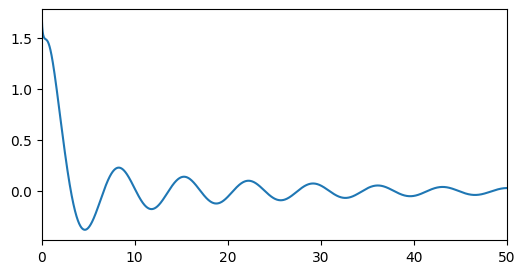

In [2]:
# Load data from model_reduction/step_response.py
step_response = np.load("re100_impulse_output/long_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


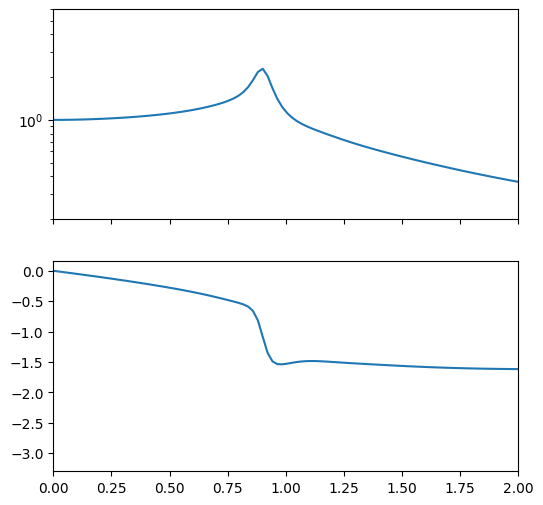

In [3]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
freqs = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [4]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


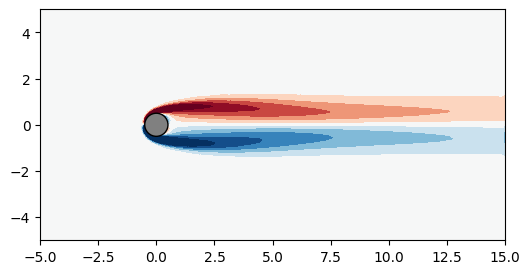

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


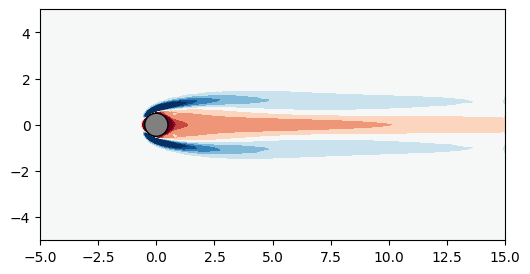

In [6]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

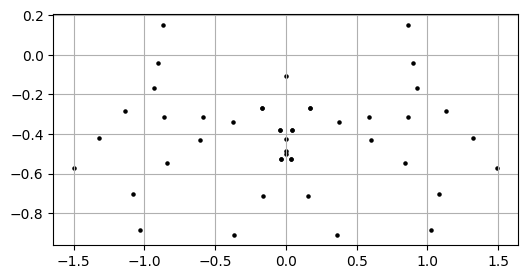

In [7]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

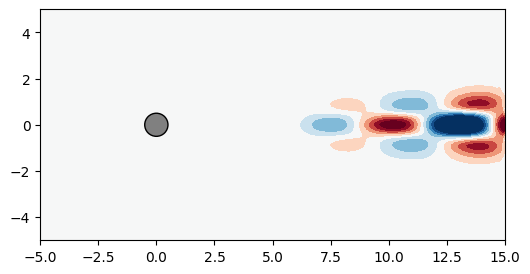

In [8]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

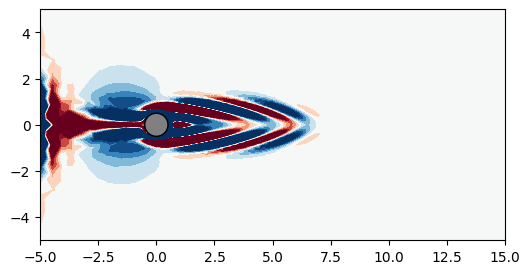

In [9]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [10]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

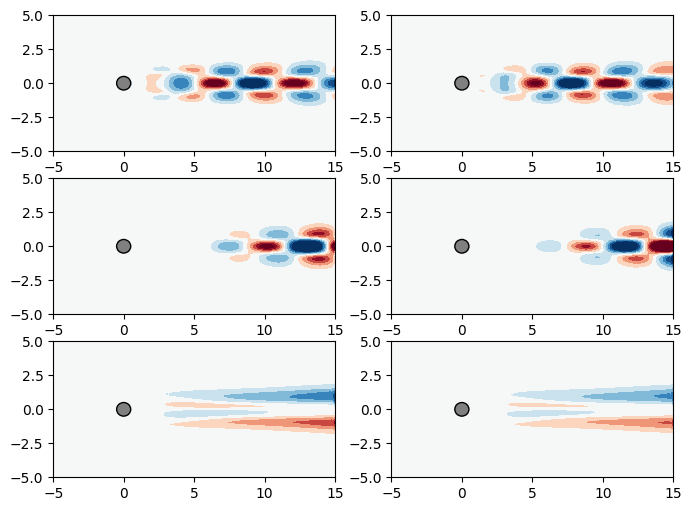

In [11]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

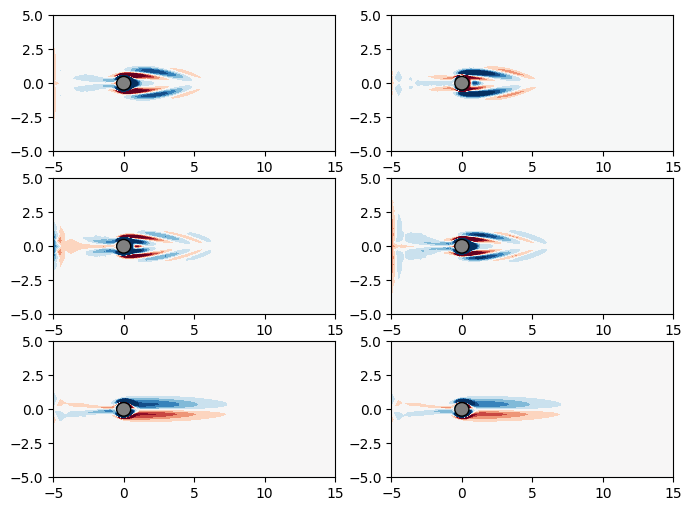

In [12]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

### Natural flow (no actuation)

In [13]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 50
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_nat[i], CD_nat[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.]
t=0.13, CL=0.0075, CD=-0.0000
   u=[0.]
t=0.14, CL=0.0073, CD=-0.0000
   u=[0.]
t=0.15, CL=0.0071, CD=-0.0000
   u=[0.]
t=0.16, CL=0.0069, CD=-0.0000
   u=[0.]
t=0.17, CL=0.0067, CD=-0.0000
   u=[0.]
t=0.18, CL=0.0065, CD=-0.0000
   u=[0.]
t=0.19, CL=0.0063, CD=-0.0000
   u=[0.]
t=0.20, CL=0.0062, CD=-0.0000
   u=[0.]
t=0.21, CL=0.0060, CD=-0.0000
   u=[0.]
t=0.22, CL=0.0058, CD=-0.0000
   u=[0.]
t=0.23, CL=0.0056, CD=-0.0000
   u=[0.]
t=0.24, CL=0.0054, CD=-0.0000
   u=[0.]


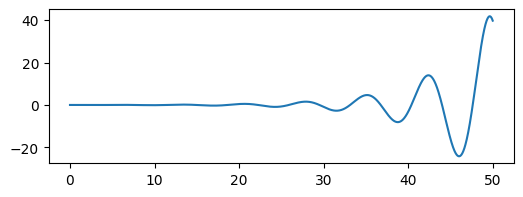

In [14]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, CL_nat)
plt.show()

### Projection onto global modes

In [495]:
# 4. Projection onto global modes

r = 9  # Number of global modes for projection
# r = len(evals)
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    # Br[i, 0] = flow.inner_product(qC, W[i])
    Br[i, 0] = flow.inner_product(W[i], qC)
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

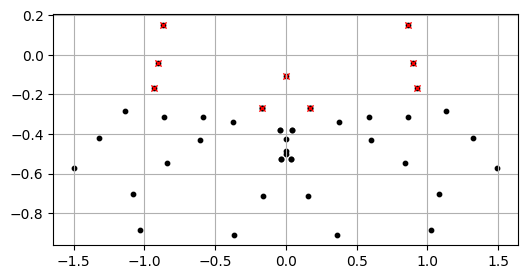

In [496]:
rom_evals = np.linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

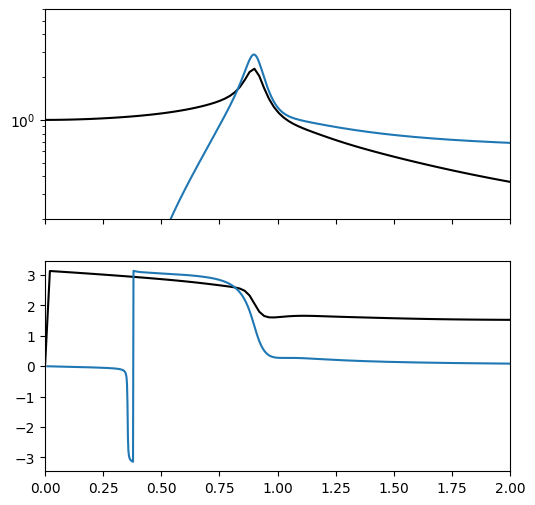

In [497]:
def H(s):
    return Cr @ np.linalg.inv(s * np.eye(r) - Ar) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [722]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # Transformation matrix such that z = T @ x
    T = np.zeros((n, n), dtype=np.cdouble)
    T[di, di] = 1.0
    T[stack_ind + (j, j)] = 0.5j
    T[stack_ind + (j, k)] = 0.5
    T[stack_ind + (k, j)] = -0.5j
    T[stack_ind + (k, k)] = 0.5

    # Transform the measurement matrix
    Cr = np.real(C.conj() @ T)  # <-- conj??

    # Transform the input matrix
    Br = np.real(linalg.inv(T) @ B.conj())

    Dr = D.real

    return Ar, Br, Cr, Dr, T


Ar_real, Br_real, Cr_real, Dr_real, T = real_form(Ar, Br, Cr, Dr)
T_inv = linalg.inv(T)

In [723]:
T_inv[:2, :2]

array([[0.-1.j, 0.+1.j],
       [1.+0.j, 1.-0.j]])

In [724]:
Br_real

array([[-6.71758154e+00],
       [-3.09125269e+00],
       [ 8.69729786e+01],
       [-2.31183384e+02],
       [ 2.69141404e-04],
       [ 3.69881290e+02],
       [ 1.43468731e+03],
       [-6.28297579e-04],
       [ 9.77137499e-03]])

In [725]:
# Need to be able to project and recover the right observation

q0 = fd.project(ufl.imag(V[1]), fn_space)
# q0 = fd.project(V[1], fn_space)
# q0 = fd.project(0.5 * (V[0] + V[1]), fn_space)
flow.q.assign(q0)
print(flow.get_observations())
# q0.assign(q0 / flow.inner_product(q0, q0))

z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
print(z0[:2])

x0 = T_inv @ z0
print(x0[:2])

print(Cr_real @ x0)

((-0.010504028052849394+0j), (1.6733698399761855e-07+0j))
[-1.11265918e-12+0.5j -1.11265918e-12-0.5j]
[ 1.00000000e+00+0.j -2.22531836e-12+0.j]
[-0.01050403+5.31269895e-19j]


In [726]:
T[:2, :2]

array([[ 0. +0.5j,  0.5+0.j ],
       [-0. -0.5j,  0.5+0.j ]])

In [727]:
Cr_real

array([[-1.05040280e-02,  4.86354662e-03, -7.38876873e-04,
        -6.82186338e-04,  6.45040779e-08,  3.44228724e-05,
        -1.69137767e-04, -2.91281255e-09, -5.89181561e-09]])

In [728]:
C_hat = Cr_real

q0 = fd.Function(flow.mixed_space).project(ufl.imag(V[0]))
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
# q0 = fd.Function(flow.mixed_space).assign(0.5j * (-V[0] + V[1]))
flow.q.assign(q0)
print(flow.get_observations())
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
print(z0[:2])
x0 = T_inv @ z0
print(x0[:2])
C_hat @ x0

((0.010504028052849394+0j), (-1.6733698399761855e-07+0j))
[1.11265918e-12-0.5j 1.11265918e-12+0.5j]
[-1.00000000e+00+0.j  2.22531836e-12+0.j]


array([0.01050403-5.31269895e-19j])

### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [729]:
complex_rom = False

if complex_rom:
    A_hat, B_hat, C_hat, D_hat = Ar, Br, Cr, Dr
else:
    A_hat, B_hat, C_hat, D_hat = Ar_real, Br_real, Cr_real, Dr_real

In [730]:
ru = 2
m = 1
p = 1

if complex_rom:
    # Low-gain limit
    Q = np.zeros((ru, ru))
    R = np.eye(m)
    P = linalg.solve_continuous_are(A_hat[:ru, :ru], B_hat[:ru], Q, R)

    K = np.zeros_like(B_hat.T)
    Ku = linalg.solve(R, B_hat[:ru].T) @ P
    K[:, :ru] = Ku
    print(Ku)

else:
    # Approximate low-gain limit with large R matrix
    Q = np.eye(r)
    R = 1e8 * np.eye(m)
    K, _, E = control.lqr(A_hat, B_hat, Q, R)
    print(K)
    print(E)

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

[[-8.87703324e-02 -2.35866160e-02 -9.26373971e-06  1.17114030e-05
   1.14927069e-11  7.86458268e-06  3.30856234e-07 -2.50001194e-11
   1.42305592e-10]]
[-0.19943592+0.93007878j -0.19943592-0.93007878j -0.04380102+0.9012339j
 -0.04380102-0.9012339j  -0.15105592+0.86674653j -0.15105592-0.86674653j
 -0.26713098+0.16929999j -0.26713098-0.16929999j -0.10587779+0.j        ]


(0.1, 10)

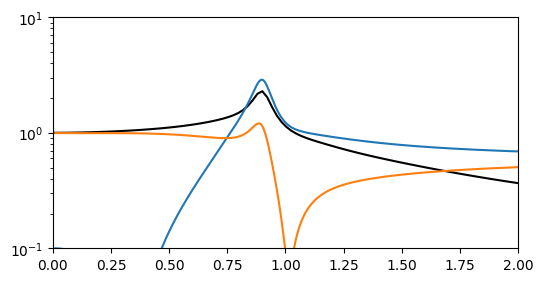

In [731]:
def H_cl(s):
    return C_hat @ np.linalg.inv(s * np.eye(r) - (A_hat + B_hat @ K)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)
ax.set_ylim(0.1, 10)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [732]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 50
n_steps = int(tf // dt)
CL_ctrl = np.zeros(n_steps)
CD_ctrl = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    # z = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

    if i > 0:
        # Transform to the real-valued reduced state space
        x[i] = np.real(T_inv @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ z)
        else:
            u[i] = K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        # u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])

        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_ctrl[i], CD_ctrl[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_ctrl[i]:.4f}, CD={CD_ctrl[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0091, CD=-0.0000
   u=[-0.04912145], rho=0.0004912145066382558
t=0.02, CL=0.0081, CD=0.0000
   u=[-0.05079946], rho=0.0009992091363425868
t=0.03, CL=0.0071, CD=0.0000
   u=[-0.05268108], rho=0.0015260199805305122
t=0.04, CL=0.0060, CD=0.0000
   u=[-0.05464021], rho=0.0020724220640310044
t=0.05, CL=0.0049, CD=0.0000
   u=[-0.0566351], rho=0.0026387730396575217
t=0.06, CL=0.0038, CD=0.0000
   u=[-0.05865193], rho=0.003225292389343751
t=0.07, CL=0.0026, CD=0.0000
   u=[-0.06068614], rho=0.0038321538132632736
t=0.08, CL=0.0014, CD=0.0000
   u=[-0.0627362], rho=0.004459515796115255
t=0.09, CL=0.0002, CD=0.0000
   u=[-0.06480159], rho=0.00510753171405633
t=0.10, CL=-0.0011, CD=0.0000
   u=[-0.06688215], rho=0.005776353170894699
t=0.11, CL=-0.0024, CD=0.0000
   u=[-0.06897779], rho=0.006466131093563327
t=0.12, CL=-0.0037, CD=0.0000
   u=[-0.0710885], rho=0.007177016085997321
t=0.13, CL=-0.0051, CD=0.0000
   u=[-0.07321425], rho=0.0

KeyboardInterrupt: 

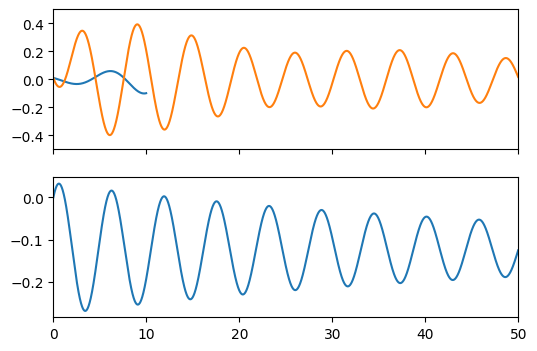

In [ ]:
t = np.arange(n_steps) * dt

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].set_ylim([-0.5, 0.5])
# ax[0].plot(t, y)
# ax[1].plot(t, x)
# ax[1].plot(t, u)
ax[1].plot(dt * np.arange(len(rho)), rho)
ax[1].set_xlim([0, 50])
plt.show()


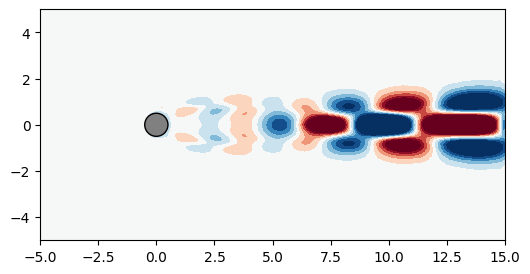

In [626]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Boundary condition control

In [611]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis).  We can pre-compute the term
# T @ (W^T @ qC) and subtract it from the full flow field projection at each step

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
xC = -np.real(T_inv @ zC)

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        # z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
        z = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

        # Transform to the real-valued reduced state space and offset by
        # the BC value to shift to the corresponding homogeneous solution
        x[i] = np.real(T_inv @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ (z - zC * rho[i-1]))
        else:
            u[i] = K @ (x[i] - xC * rho[i-1])

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0091, CD=0.0000
   u=[-0.04702836], rho=[0.00047028]
t=0.02, CL=0.0084, CD=-0.0000
   u=[-0.04532741], rho=[0.00092356]
t=0.03, CL=0.0078, CD=-0.0000
   u=[-0.04351981], rho=[0.00135876]
t=0.04, CL=0.0071, CD=-0.0000
   u=[-0.04167964], rho=[0.00177555]
t=0.05, CL=0.0065, CD=-0.0000
   u=[-0.03983165], rho=[0.00217387]
t=0.06, CL=0.0059, CD=-0.0000
   u=[-0.03798417], rho=[0.00255371]
t=0.07, CL=0.0054, CD=-0.0000
   u=[-0.03614009], rho=[0.00291511]
t=0.08, CL=0.0049, CD=-0.0000
   u=[-0.03430046], rho=[0.00325812]
t=0.09, CL=0.0043, CD=-0.0000
   u=[-0.03246575], rho=[0.00358277]
t=0.10, CL=0.0039, CD=-0.0000
   u=[-0.03063621], rho=[0.00388914]
t=0.11, CL=0.0034, CD=-0.0000
   u=[-0.02881203], rho=[0.00417726]
t=0.12, CL=0.0029, CD=-0.0000
   u=[-0.02699337], rho=[0.00444719]
t=0.13, CL=0.0025, CD=-0.0000
   u=[-0.0251804], rho=[0.00469899]
t=0.14, CL=0.0021, CD=-0.0000
   u=[-0.02337325], rho=[0.00493273]
t=0.15, CL=0.0

KeyboardInterrupt: 

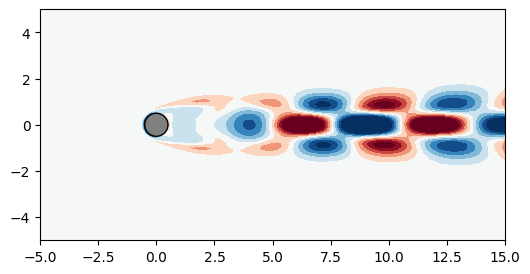

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

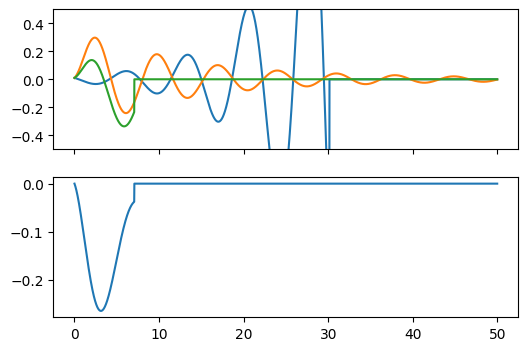

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].plot(dt * np.arange(len(CL_bc)), CL_bc)
ax[0].set_ylim([-0.5, 0.5])

# ax[1].plot(t, CD_ctrl)
# ax[1].plot(t, CD_bc)

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

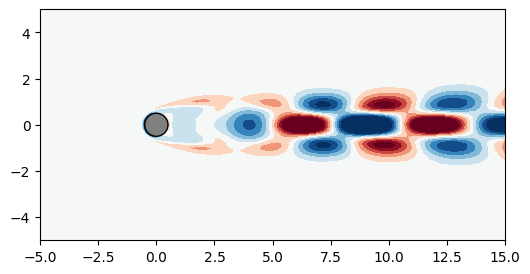

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

# NEXT STEPS

* Kalman filter: test estimation while keeping full-state feedback
* LQG: combine Kalman filter with LQR
* BPOD: collect snapshots from direct and adjoint simulations
* Balanced model reduction for stable subspace

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [734]:
# kf_sys = control.ss(A_hat, np.hstack((B_hat, L)), C_hat, np.hstack((D_hat, [0.0])))
# np.hstack((B_hat, L)).shape

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

### No control

In [735]:
C_hat

array([[-1.05040280e-02,  4.86354662e-03, -7.38876873e-04,
        -6.82186338e-04,  6.45040779e-08,  3.44228724e-05,
        -1.69137767e-04, -2.91281255e-09, -5.89181561e-09]])

In [736]:
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
q0 = fd.Function(flow.mixed_space).assign(0.5j * (V[0] - V[1]))
flow.q.assign(q0)
print(flow.get_observations())
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
# z0 = np.array([flow.inner_product(W[j], q0) for j in range(r)])
x0 = np.real(T_inv @ z0)
C_hat @ x0

((-0.010504028045981677+0j), (1.6733791403307258e-07+0j))


array([-0.01050403])

In [737]:
x0

array([ 1.00000000e+00,  4.42838989e-16, -1.54837962e-15,  1.40648703e-14,
        7.99966767e-16, -1.51891080e-13,  1.04532756e-13,  2.76821358e-13,
       -1.50510711e-13])

In [738]:
flow.q.assign(-0.5j * (V[0] - V[1]))
flow.get_observations()

((0.010504028045981677+0j), (-1.6733791403307258e-07+0j))

In [739]:
# Kalman filter

if complex_rom:
    L = np.zeros_like(C_hat.T)
    Rf = np.eye(p)
    Pf = linalg.solve_continuous_are(A_hat[:ru, :ru].T.conj(), C_hat[:, :ru].T.conj(), Q, Rf)
    Lu = linalg.solve(Rf, C_hat[:, :ru].conj()) @ Pf
    L[:ru, :] = Lu.T
    print(Lu)

    # Kalman filter (discrete)
    def design_dlqe(A, C):
        Q = np.zeros_like(A)
        R = np.eye(C.shape[0], dtype=C.dtype)
        P = linalg.solve_discrete_are(A.T.conj(), C.T.conj(), Q, R)
        L = linalg.solve(C @ P @ C.T.conj() + R, C @ P @ A.T.conj())
        return L.T.conj()

    L = np.zeros_like(C_hat.T)
    L[:ru, :] = design_dlqe(A_kf[:ru, :ru], C_kf[:, :ru])
    L[:ru]
else:
    Qf = np.eye(r)
    Rf = 1e8 * np.eye(p)
    L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
    L = L.T
    print(L)
    print(np.log(E) / dt)

[[-5.09924812e-01]
 [ 1.40989814e-01]
 [ 6.49675368e-09]
 [ 2.94812633e-09]
 [ 2.80054260e-13]
 [ 1.00233141e-10]
 [-1.22367233e-11]
 [-5.14862510e-15]
 [-1.05401820e-14]]
[-0.04123426+0.90116992j -0.04123426-0.90116992j -0.15105472+0.86674647j
 -0.15105472-0.86674647j -0.16956155+0.93016196j -0.16956155-0.93016196j
 -0.10587779+0.j         -0.26713098+0.16929999j -0.26713098-0.16929999j]


In [740]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 10.0
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Kalman filter estimate
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output
u = np.zeros((n_steps, m))  # Control signal

y_proj = np.zeros((n_steps, p))  # Projected measurement

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL, CD = map(np.real, flow.get_observations())
    CL_nat[i], CD_nat[i] = CL, CD

    # Project the flow field onto the reduced basis
    # Note that this will be complex
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])
    # x[i] = np.array([flow.inner_product(W[j], flow.q) for j in range(r)])

    if not complex_rom:
        x[i] = (T_inv @ x[i])

    # Update the Kalman filter estimate 
    y[i] = CL
    y_proj[i] = C_hat @ x[i]
    if i > 0:
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}, y={y[i]}, y_hat={y_hat[i]}, y_proj={y_proj[i]}")

/tmp/ipykernel_41488/1033053844.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  y_proj[i] = C_hat @ x[i]


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], y=[0.00978918], y_hat=[0.], y_proj=[0.00978918]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.], y=[0.00963618], y_hat=[0.], y_proj=[0.00963618]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.], y=[0.00946944], y_hat=[5.82215809e-05], y_proj=[0.00946944]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.], y=[0.00929729], y_hat=[0.00011525], y_proj=[0.00929729]


In [588]:
x_rom = np.zeros_like(x)
x_rom[0] = x[0]

for i in range(1, n_steps):
    x_rom[i] = A_kf @ x_rom[i-1]

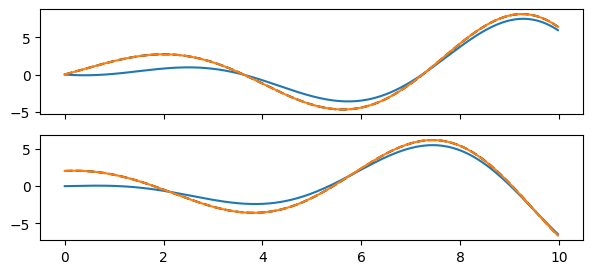

In [589]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
if complex_rom:
    z_plt = z * np.exp(1j * 5*np.pi/4)  # Phase shifted from true state
    ax[0].plot(t, np.real(x[:, 0]), 'k--')
    ax[0].plot(t, np.real(z_plt[:, 0]))
    ax[1].plot(t, np.imag(x[:, 0]), 'k--')
    ax[1].plot(t, np.imag(z_plt[:, 0]))
else:
    ax[0].plot(t, x[:, 0], 'k--')
    ax[0].plot(t, z[:, 0])
    ax[0].plot(t, x_rom[:, 0].real)
    ax[1].plot(t, x[:, 1], 'k--')
    ax[1].plot(t, z[:, 1])
    ax[1].plot(t, x_rom[:, 1].real)
plt.show()

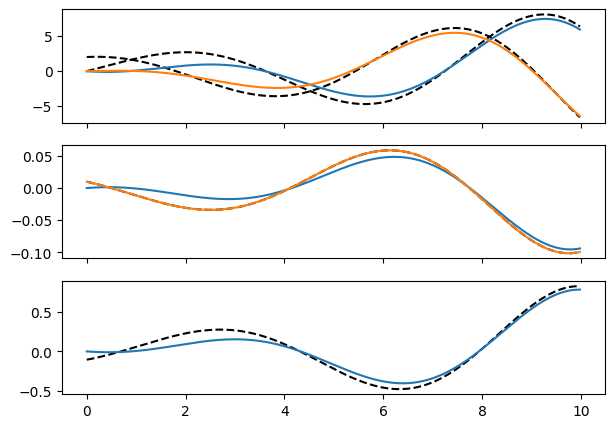

In [590]:

# Transform the measurement matrix


t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, :2]), 'k--')
ax[0].plot(t, np.real(z[:, :2]))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[1].plot(t, x @ C_hat.T)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z @ K.T)
plt.show()

### Kalman filter with forcing

For simplicity, run this with the explicit forcing control (instead of BC control).  This fails, showing that the global modes are not sufficient to construct a model that will capture the input/output behavior

In [231]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

tf = 10.0
n_steps = int(tf // dt)
CL_lqg = np.zeros(n_steps)
CD_lqg = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=complex)  # Reduced state
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
u = np.zeros((n_steps, m))  # Control signal
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output

# Integrated control signal (this is the BC value)
rho = np.zeros(n_steps)

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_lqg[i], CD_lqg[i] = map(np.real, flow.get_observations())

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    y_est = 0.0
    y[i] = CL_lqg[i]
    if i > 0:
        # Estimate using true projection.. this should match y[i] reasonably well
        # provided the ROM is a good approximation
        y_est = np.real(C_hat @ x[i-1])

        # No feedthrough term here since we are using the homogeneous state
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

        # Steady forcing
        u[i] = 0.1

        c.assign(u[i])

        rho[i] = rho[i-1] - dt * u[i]

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_lqg[i]:.4f}, CD={CD_lqg[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}, y_hat={y_hat[i]} y_est={y_est}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0, y_hat=[0.] y_est=0.0
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.1], rho=-0.001, y_hat=[0.] y_est=[0.01021473]
t=0.02, CL=0.0106, CD=-0.0000
   u=[0.1], rho=-0.002, y_hat=[5.82216835e-05] y_est=[0.01032764]
t=0.03, CL=0.0120, CD=-0.0000
   u=[0.1], rho=-0.003, y_hat=[2.90165105e-06] y_est=[0.01041836]
t=0.04, CL=0.0135, CD=-0.0000
   u=[0.1], rho=-0.004, y_hat=[-4.42759318e-05] y_est=[0.01050113]
t=0.05, CL=0.0150, CD=-0.0000
   u=[0.1], rho=-0.005, y_hat=[-8.26934238e-05] y_est=[0.01058066]
t=0.06, CL=0.0165, CD=-0.0000
   u=[0.1], rho=-0.006, y_hat=[-0.00011224] y_est=[0.01065852]
t=0.07, CL=0.0180, CD=-0.0000
   u=[0.1], rho=-0.007, y_hat=[-0.00013294] y_est=[0.01073524]
t=0.08, CL=0.0194, CD=-0.0000
   u=[0.1], rho=-0.008, y_hat=[-0.0001449] y_est=[0.01081097]
t=0.09, CL=0.0209, CD=-0.0000
   u=[0.1], rho=-0.009000000000000001, y_hat=[-0.00014819] y_est=[0.01088577]
t=0.10, CL=0.0224, CD=-0.0000
   u=[0.1], rho=-0.010000000000000002, y_ha

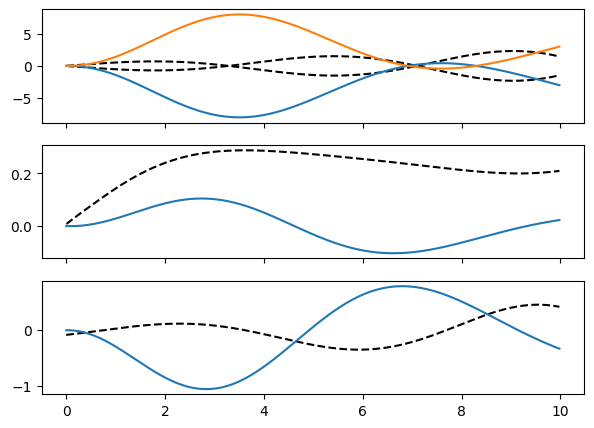

In [232]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.imag(x[:, :2]), 'k--')
ax[0].plot(t, np.imag(z[:, :2].conj()))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z.conj() @ K.T)
plt.show()